# Clase 2 - Ejercicio 8
<br/>

## Curso de Especialización en Inteligencia Artificial
## Introducción a la inteligencia artificial
<br/>

### Autor: Maximiliano Torti
### Fecha: 09/05/21
<br/>

#### Enunciado:<br/>
1. Utilizar un dataset de su preferencia, puede ser de su proyecto final u otro.
2. Cambiar algunos puntos de manera aleatoria y agregar NaN (0.1% del dataset).
3. Guardar el dataset en un .pkl
4. Cargar el dataset con Numpy desde el .pkl
5. Completar NaN con la media de cada feature.
6. Calcular la norma l2, la media y el desvío de cada feature con funciones numpy vectorizadas.
7. Aplicar PCA al dataset reduciendo a M dimensiones.
a. Analizar la contribución de cada componente.
b. Realizar un scree plot.
c. Graficar el cluster en 2 y 3 dimensiones.
d. A través de análisis estadísticos, sacar conclusiones respecto de los resultados de PCA.
8. Hacer la clusterización con el k-means desarrollado en clase.
9. Volver a graficar el cluster con lo obtenido en (8) y comparar resultados con (7).

#### Introduccion:<br/>

Utilizaremos como dataset, un dataset privado que voy a utilizar como parte de mi proyecto.
Del mismo extraemos una señal que indica la fuerza aplicada para crear un sello en materiales con cavidades que se someten a alta presión interna como parte de su testeo de calidad.

A continuación se muestra un ejemplo de dicha señal:

<br/>

<div style="clear: both">
<img src="resultados/Figure_0.png" >
</div>

<br/>

La señal comienza en cero por unos segundos hasta que se forma el sello, y luego se aplica fuerza para mantener el sello con alta presión interna.

Una anomalía común es que el sello pierda fuerza por fugas o fisuras. El dataset utilizado contiene 200 ciclos de testeo correctos y 200 ciclos con anomalía.


In [86]:
#Importamos librerias
import numpy as np
import pandas as pd

%matplotlib notebook
from matplotlib import pyplot as plt
plt.style.use(['seaborn-darkgrid'])
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.family'] = 'DejaVu Sans'

import pickle as pkl
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score


<IPython.core.display.Javascript object>


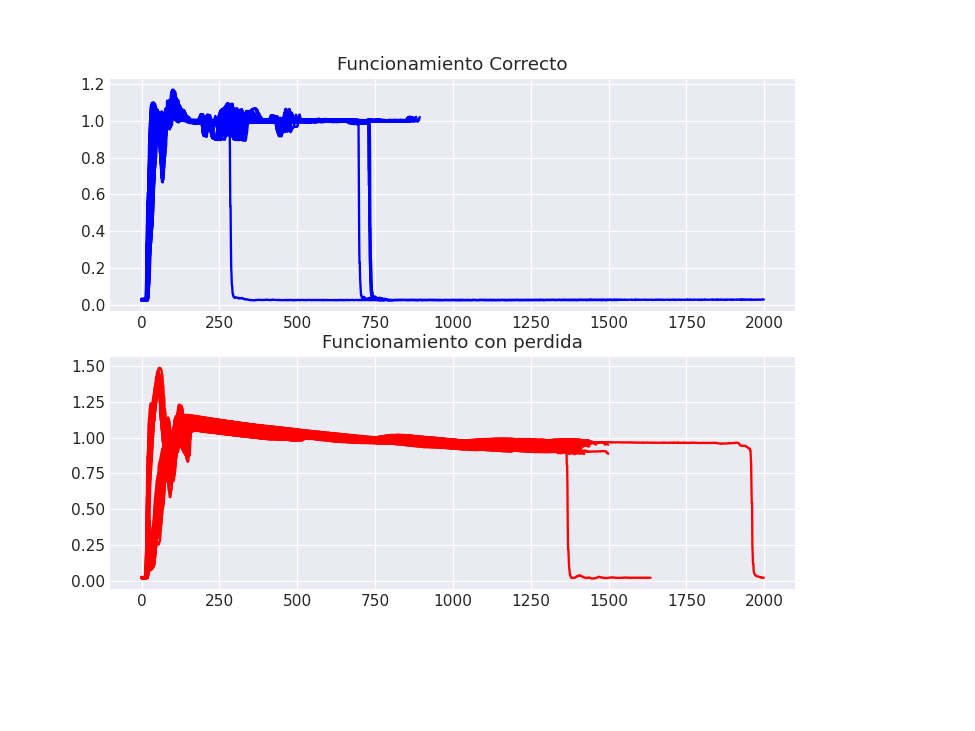

Text(0.5, 1.0, 'Funcionamiento con perdida')

In [38]:
# Cargamos el dataset y graficamos ambas clases
dataset=np.array(pd.read_csv('./dataset/dataset.csv', delimiter=';',header=None))

#Primer columna es la clase (1: normal, 2:anomalia)
data_class=dataset[:,0]
data=dataset[:,1:]

#Graficamos el dataset
fig, axs = plt.subplots(2,figsize=(8,6))
for i in range(0,200):
    axs[0].plot(data[i,:],color='blue',label=None)
axs[0].set_title("Funcionamiento Correcto")

for i in range(200,400):
    axs[1].plot(data[i,:],color='red',label=None)
axs[1].set_title("Funcionamiento con perdida")



<IPython.core.display.Javascript object>


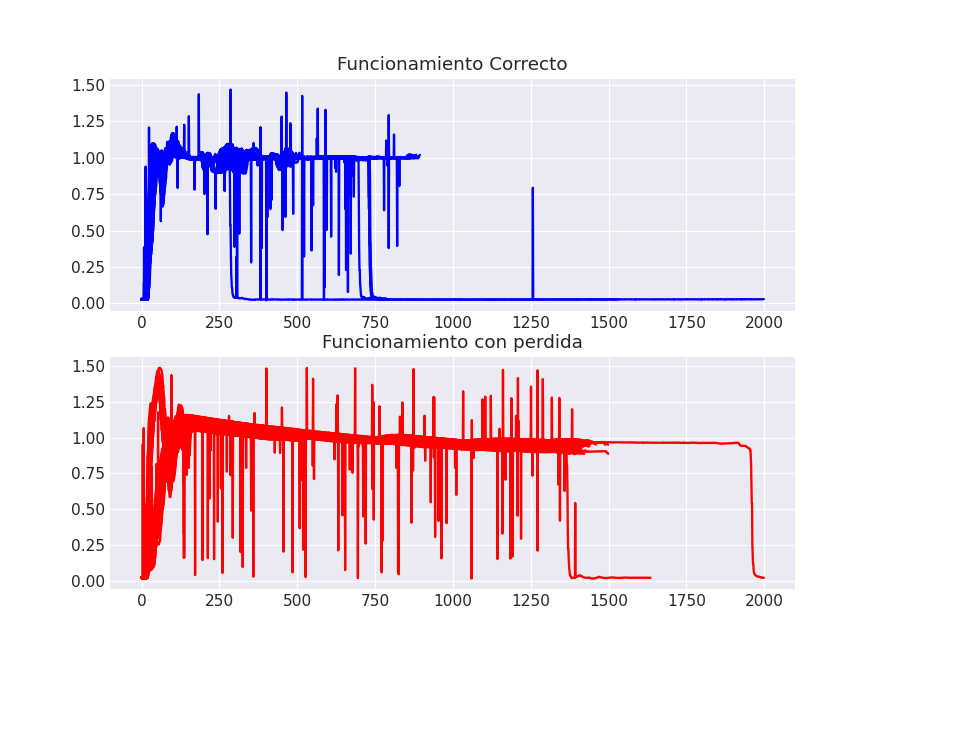

Text(0.5, 1.0, 'Funcionamiento con perdida')

In [39]:
# Cambiamos puntos de manera aleatoria 
rand_change=np.random.randint(0,10000,size=data.shape)<5
rand_values=np.random.uniform(low=np.nanmin(data), \
                              high=np.nanmax(data), \
                                  size=rand_change.sum())
data[rand_change]=rand_values

# Agregamos NaN en forma aleatoria (0.05% del total del dataset)
# Tener en cuenta que el dataset ya contiene NaN por tener ciclos de diferente duración
nan_change=np.random.randint(0,10000,size=data.shape)<5
nan_values=np.nan*np.ones(shape=nan_change.sum())
data[nan_change]=nan_values

#Graficamos el dataset con "ruido"
fig, axs = plt.subplots(2,figsize=(8,6))
for i in range(0,200):
    axs[0].plot(data[i,:],color='blue',label=None)
axs[0].set_title("Funcionamiento Correcto")

for i in range(200,400):
    axs[1].plot(data[i,:],color='red',label=None)
axs[1].set_title("Funcionamiento con perdida")



In [45]:
# Grabamos en pickle
# Quitar comentarios para sobre-escribir
#with open('./dataset/dataset.pkl','wb') as file:
#    pkl.dump(data,file,protocol=pkl.HIGHEST_PROTOCOL)
    
#with open('./dataset/dataset_classes.pkl','wb') as file:
#    pkl.dump(data_class,file,protocol=pkl.HIGHEST_PROTOCOL)

In [46]:
#Cargamos el dataset con pickle
with open('./dataset/dataset.pkl','rb') as file:
    data=pkl.load(file)
    
with open('./dataset/dataset_classes.pkl','rb') as file:
    data_classes=pkl.load(file)

In [47]:
# Observando las figuras anteriores, no tiene sentido analizar las señales luego del indice 800
# Nos centraremos unicamente en ese rango
data=data[:,0:800]

In [48]:
#Completamos NaN con media de cada feature
def replace_nan(x):
    """
    Reemplaza NaN por la media de la columna
    
    Args:
        X (numpy array): matriz de entrada
        
    Returns:
        numpy array: matriz con NaN reemplazados
    """
    valid=np.logical_not(np.isnan(x))
    col_avg=x.sum(axis=0,where=valid) /valid.sum(axis=0,where=valid) 
    col_avg=col_avg[np.newaxis,:]
    col_avg= np.repeat(col_avg,x.shape[0],axis=0)
    x[np.isnan(x)]=col_avg[np.isnan(x)]
    return x

data=replace_nan(data)

<IPython.core.display.Javascript object>


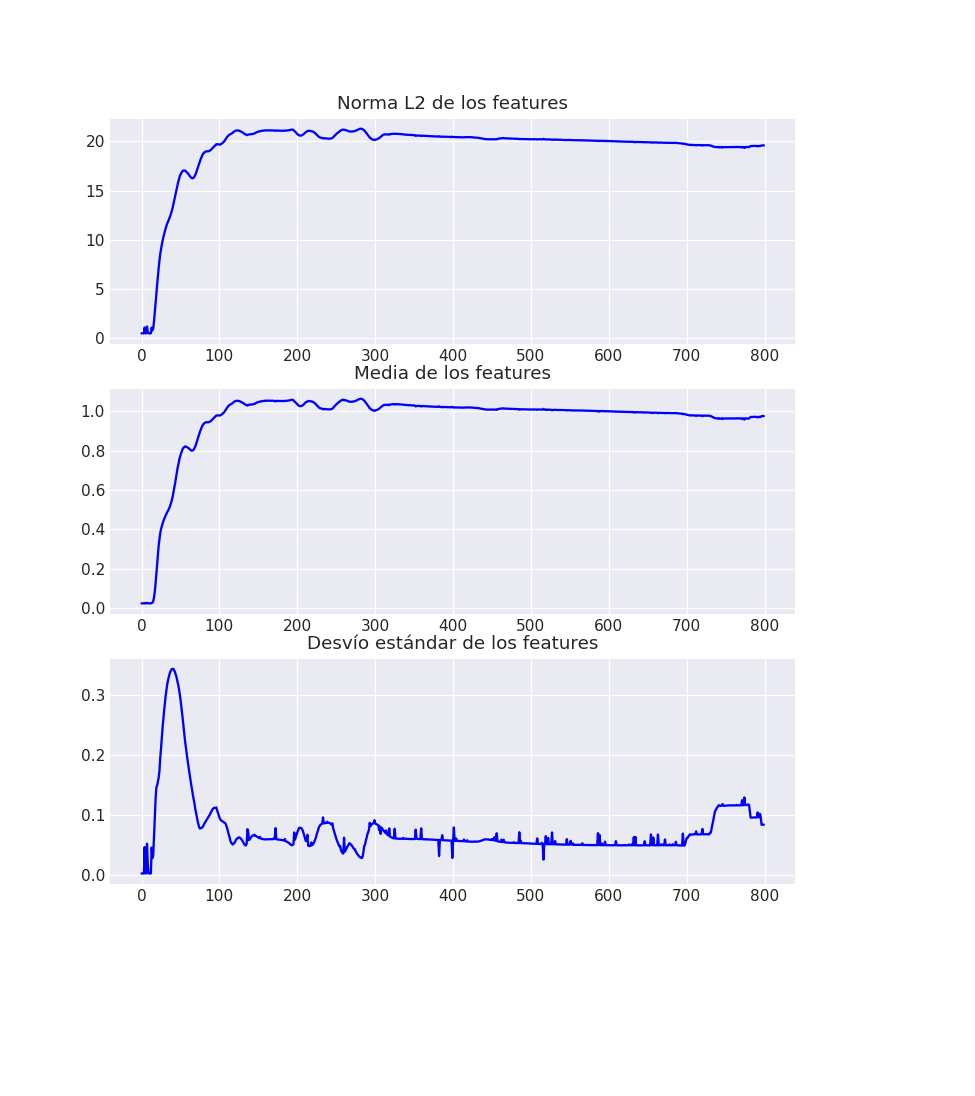

Text(0.5, 1.0, 'Desvío estándar de los features')

In [49]:
#Calculamos norma L2, media y desvío estandar de cada feature
l2_features=np.power(np.sum(np.power(np.abs(data),2),axis=0),1/2)
avg_features=np.mean(data,axis=0)
std_features=np.std(data,axis=0)

fig, axs = plt.subplots(3,figsize=(8,9))
axs[0].plot(l2_features,color='blue',label=None)
axs[0].set_title("Norma L2 de los features")
axs[1].plot(avg_features,color='blue',label=None)
axs[1].set_title("Media de los features")
axs[2].plot(std_features,color='blue',label=None)
axs[2].set_title("Desvío estándar de los features")


Se observa que tanto la norma L2 como la media comienzan cercano a cero para las primeras mmuestras y luego crecen a 20 y 1 respectivamente para la zona donde se debe mantener el sello.

<br/>

El desvío estandar se mantiene bajo prátcicamente en todos los puntos excepto por el momento donde aumenta bruscamente la fuerza, lo cual es esperable.


<IPython.core.display.Javascript object>


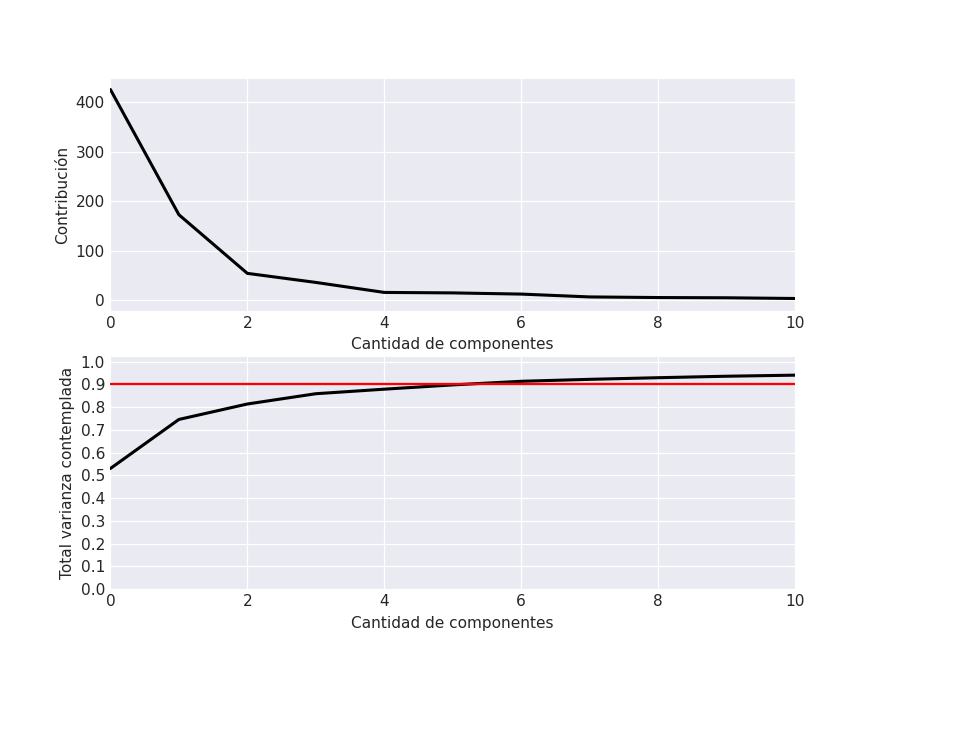

In [50]:
# Aplicamos PCA para reducir las dimensiones.

# Estandarizamos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(data)

# Primero calculamos con 100 componentes y analizamos la contribución de cada componente
pca = PCA(n_components=100, random_state=0).fit(X_scaled)

#Graficamos scree plot y varianza acumulada
fig, axs = plt.subplots(2,figsize=(8,6))
axs[0].plot(pca.explained_variance_, color='k', lw=2)
axs[0].set_xlabel('Cantidad de componentes')
axs[0].set_ylabel('Contribución')
axs[0].set_xlim(0, 10)
axs[1].plot(np.cumsum(pca.explained_variance_ratio_), color='k', lw=2)
axs[1].set_xlabel('Cantidad de componentes')
axs[1].set_ylabel('Total varianza contemplada')
axs[1].set_xlim(0, 10)
axs[1].set_yticks(np.arange(0, 1.1, 0.1))
axs[1].axhline(0.9, c='r')
plt.show();

In [51]:
# Con solo 5 componentes ya explicamos el 90% de la varianza
pca = PCA(n_components=5, random_state=0).fit(X_scaled)
X_pca = pca.transform(X_scaled)                   

<IPython.core.display.Javascript object>


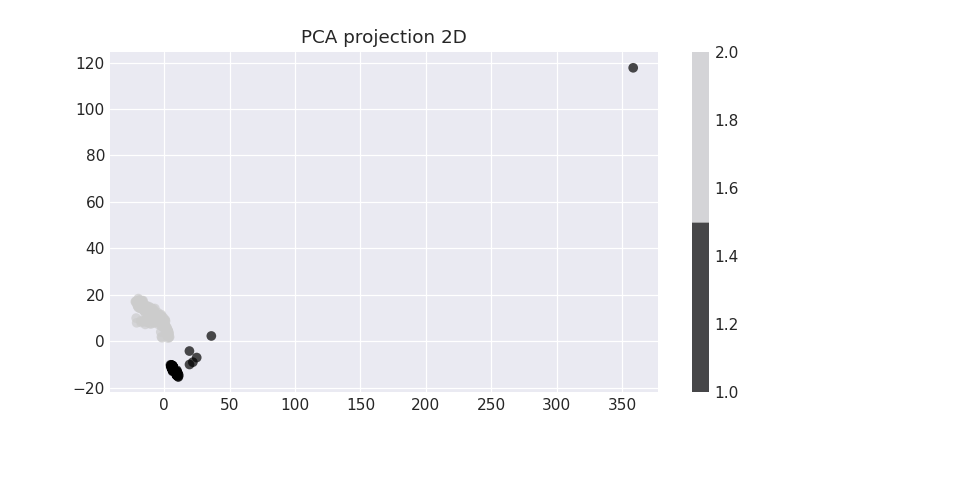

In [53]:
# Graficamos los primeros dos componentes
plt.figure(1,figsize=(8,4))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=data_classes, edgecolor='none',\
            alpha=0.7, s=40, cmap=plt.cm.get_cmap('nipy_spectral', 2))
plt.colorbar()
plt.title('PCA projection 2D');

Notemos que con solo 2 componentes, las clases son fácilmente identificables

<IPython.core.display.Javascript object>


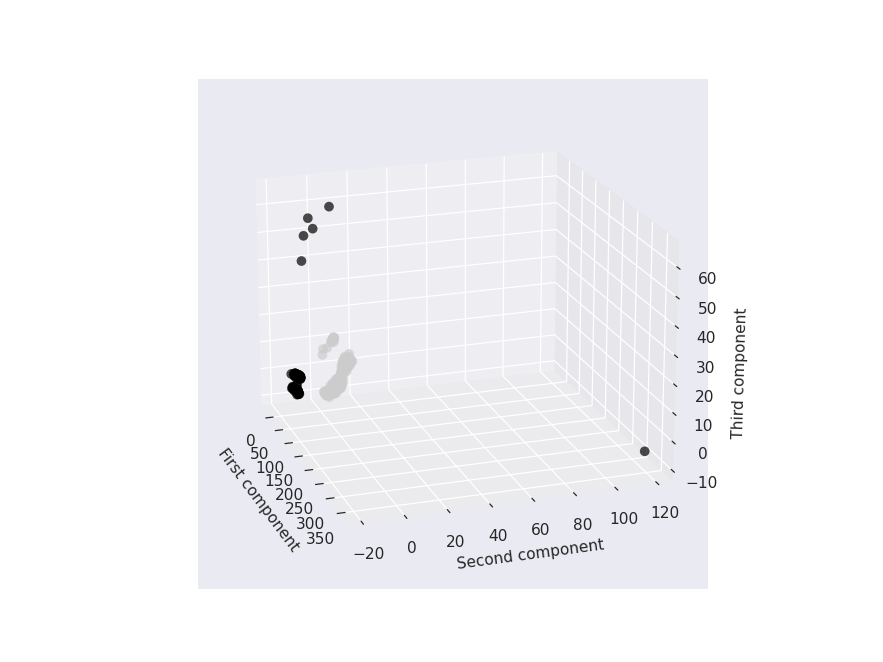

Text(0.5, 0, 'Third component')

In [54]:
# Graficamos las primeras tres componentes para realizar un grafico 3d          
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=data_classes, edgecolor='none',\
            alpha=0.7, s=40, cmap=plt.cm.get_cmap('nipy_spectral', 2))
ax.set_xlabel('First component')
ax.set_ylabel('Second component')
ax.set_zlabel('Third component')

En el gráfico 3D notamos que la descomposición en PCA con 3 componentes separa entre 5-6 grupos.

# FALTA PUNTO D

<IPython.core.display.Javascript object>


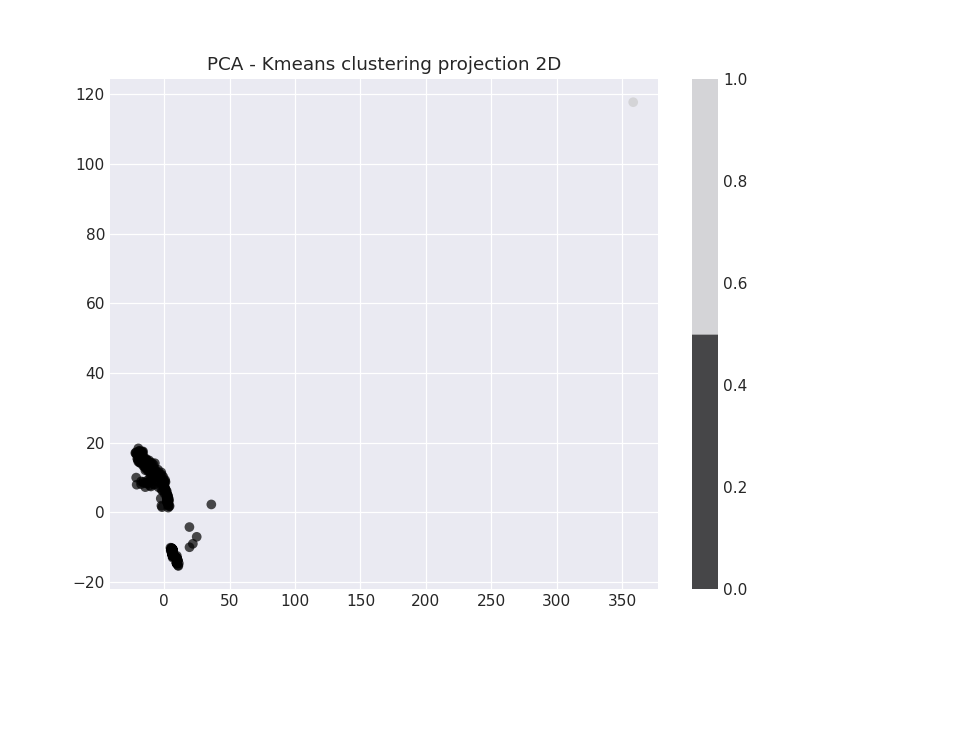

In [55]:
# Aplicamos clusterización con k-means utilizando 2 clusters
kmeans = KMeans(n_clusters=2, n_init=100, random_state=0)
kmeans.fit(X_pca)
cluster_labels = kmeans.labels_

# Graficamos en 2D
plt.figure(figsize=(8,6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, edgecolor='none', \
            alpha=0.7, s=40, cmap=plt.cm.get_cmap('nipy_spectral', 2))
plt.colorbar()
plt.title('PCA - Kmeans clustering projection 2D');

Observamos que los grupos no fueron correctamente identificados por la presencia de outliers. Intentenmos con 3 grupos.

<IPython.core.display.Javascript object>


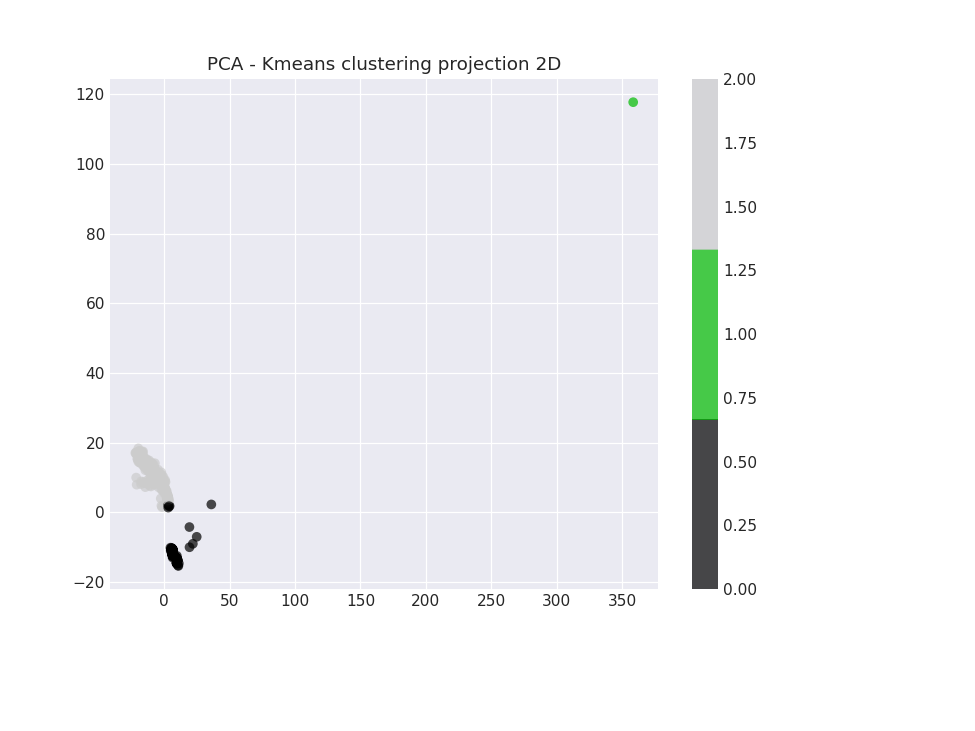

In [56]:
kmeans3 = KMeans(n_clusters=3, n_init=100, random_state=0)
kmeans3.fit(X_pca)
cluster_labels3= kmeans3.labels_

# Graficamos en 2D
plt.figure(figsize=(8,6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels3, edgecolor='none', \
            alpha=0.7, s=40, cmap=plt.cm.get_cmap('nipy_spectral', 3))
plt.colorbar()
plt.title('PCA - Kmeans clustering projection 2D');

Obsrvamos que, uniendo el cluster 2 y 0, el resultado es perfecto excepto por una sola muestra. Para validar, calculamos la tabla de verdad.

In [65]:
tab = pd.crosstab(data_classes, cluster_labels3, margins=True)
tab.index = ['Ciclos Normales', 'Ciclos anómalos','Todos']
tab.columns = ['cluster ' + str(i + 0) for i in range(3)] + ['Todos']
tab

,cluster 0,cluster 1,cluster 2,Todos
Ciclos Normales,199,1,0,200
Ciclos anómalos,4,0,196,200
Todos,203,1,196,400


<IPython.core.display.Javascript object>


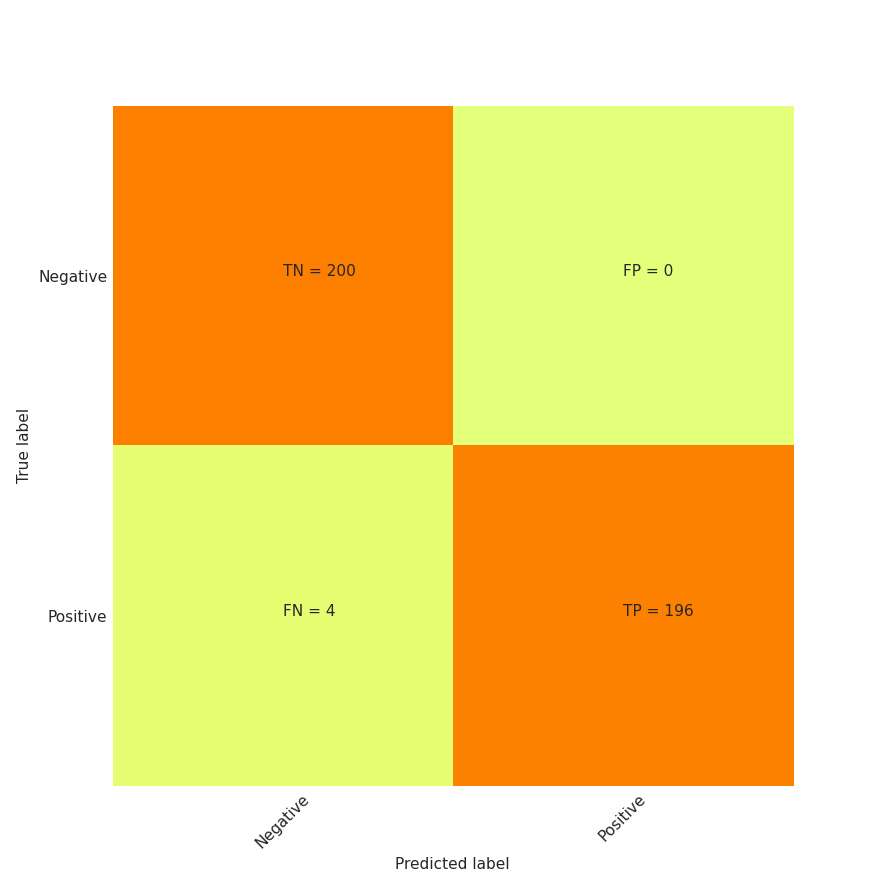

In [76]:
y_true=data_classes
#Unifico cluser 0 y cluster 1. Normalizo a clase 1 y clase 2
y_pred= (cluster_labels3 == 2) + 1
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Negative','Positive']
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.grid(False)
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]

for i in range(2):
    for j in range(2):
       plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
plt.show()


In [87]:
kmeans_precision=precision_score(y_true, y_pred)
kmeans_recall=recall_score(y_true, y_pred)
kmeans_accuracy=accuracy_score(y_true, y_pred)
kmeans_f1score=f1_score(y_true, y_pred)

print("Precision: {:.2f}".format(kmeans_precision))
print("Recall: {:.2f}".format(kmeans_recall))
print("Accuracy: {:.2f}".format(kmeans_accuracy))
print("F1-Score: {:.2f}".format(kmeans_f1score))


Precision: 0.98
Recall: 1.00
Accuracy: 0.99
F1-Score: 0.99


Tener en cuenta que si bien estos resultados parecen excelentes, estan aplicados al dataset de entrenamiento. Para validar realmente que los resultados sean buenos, hay que dividir el dataset entre entrenamiento y testeo y verificar con la porción de testeo.

Como adicional, vamos a clusterizar en 6 grupos y chequearemos que graficas pertenecen a cada grupo separado por PCA.

<IPython.core.display.Javascript object>


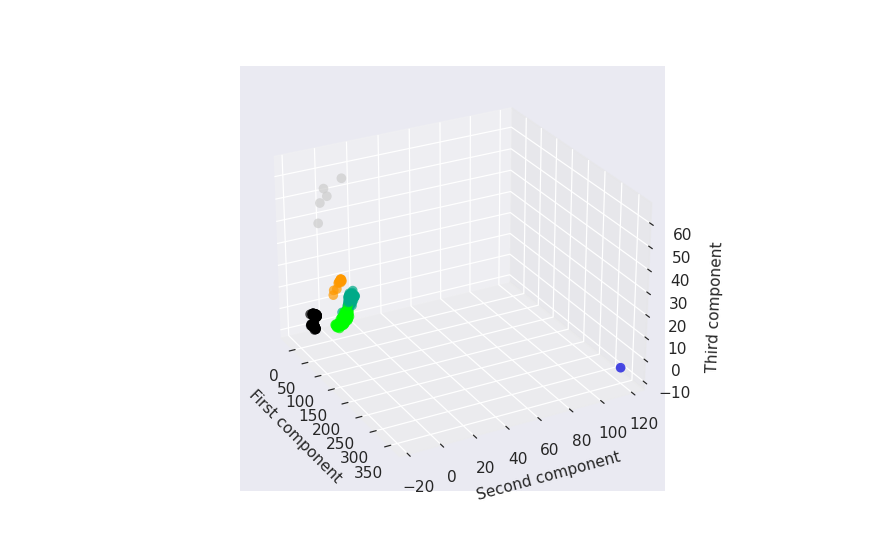

Text(0.5, 0, 'Third component')

In [57]:
kmeans6 = KMeans(n_clusters=6, n_init=100, random_state=0)
kmeans6.fit(X_pca)
cluster_labels6 = kmeans6.labels_

# Graficamos en 3D
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=cluster_labels6, edgecolor='none',\
            alpha=0.7, s=40, cmap=plt.cm.get_cmap('nipy_spectral', 6))
ax.set_xlabel('First component')
ax.set_ylabel('Second component')
ax.set_zlabel('Third component')


Observamos una definida separación entre los clusters. quiza se podría separar en forma distinta los clusters verdes y el negro, pero en general el resultado es muy bueno.

<br>

Ahora graficamos cada cluster para observar que agrupamiento realizó el algoritmo

<IPython.core.display.Javascript object>


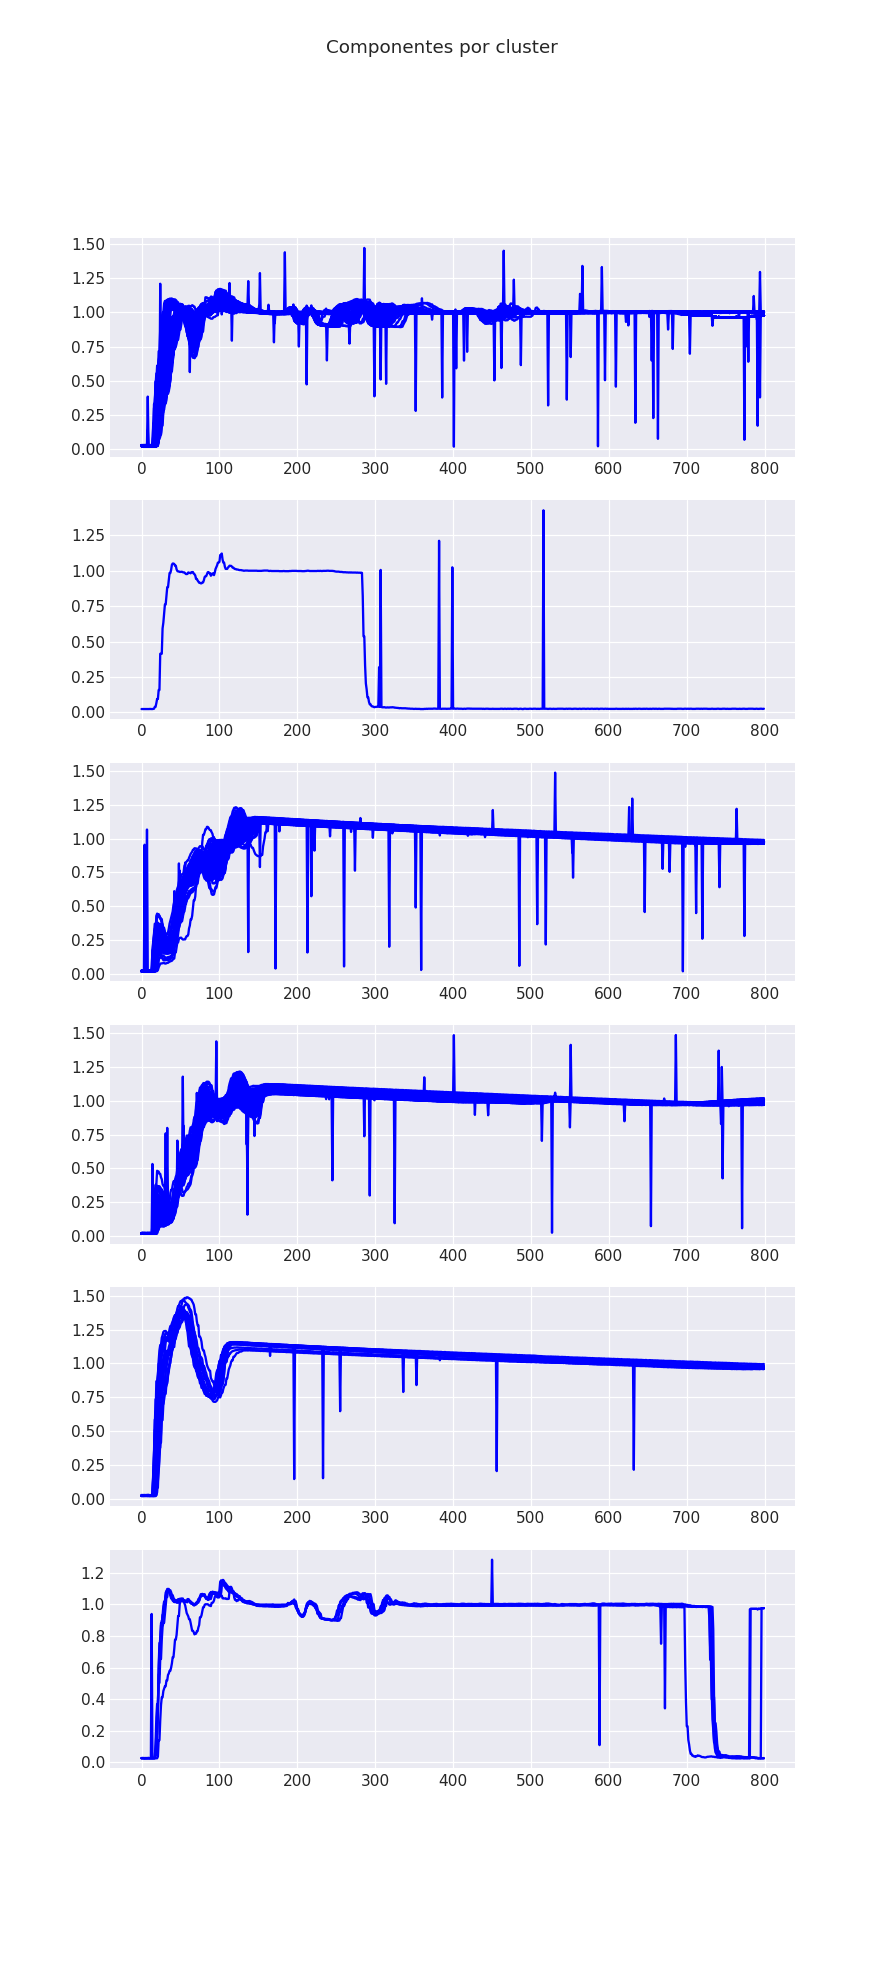

Text(0.5, 0.98, 'Componentes por cluster')

In [58]:
#Graficamos los 6 clusters
fig, axs = plt.subplots(6,figsize=(8,18))

colors=plt.nipy_spectral()

for j in range(0,6):
    for i in range(0,400):
        if cluster_labels6[i]==j:
            axs[j].plot(data[i,:],color='blue',label=None)
fig.suptitle("Componentes por cluster")


Observamos:
- El cluster 1 (puntos en negro) corresponde a ciclos correctos. 
- Cluster 2 (puntos en azul) corresponde a un ciclo correcto pero de menor duración. Como nota, la menor duración se debe al tipo de material ensayado que debe tener dimensiones menores que el resto.
- Cluster 3 (puntos en verde oscuro) son ciclos anómalos.
- Cluster 4 (puntos en verde claro) son ciclos anómalos. La diferencia con el cluster 3 parece estar en las oscilaciones en la elevación inicial de la fuerza.
- Cluster 5 (puntos en naranja) son ciclos anómalos. En este caso el control de la máquina parece tener problemas lo cual produce un gran sobrevalor en la elevación inicial de la fuerza.
- Cluster 6 (puntos en gris claro) son ciclos correctos. La diferencia con el cluster 1 parece radicar en la duración del ciclo.

<br>

*Nota: Este método, aplicado en este caso, parece ser suceptible a la duración de los ciclos. Si esta feature no es de interes, podríamos normalizar (estirar o comprimir) todos los ciclos a una duración media; o, mejor, normalizar contra la duración media del ciclo esperada según el tipo de producto.*